In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

Read the data for Temperature, Stirring, Feed of Glucose, Base, Acid, dissolved O2, ph, air feed and Offgas

In [2]:
df_T=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Temperature_Value.csv', sep=';')
df_stir=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Stirrer_Value.csv', sep=';')
df_feed1=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Feed 1_Value.csv', sep=';')
df_base=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Base_Value.csv', sep=';')
df_acid=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Acid_Value.csv', sep=';')
df_pO2=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_pO₂_Value.csv', sep=';')
df_pH=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_pH_Value.csv', sep=';')
df_air=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Flow - Air_Value.csv', sep=';')
df_offgas=pd.read_excel('fermentation raw data/offgas_data.xlsx')

In [3]:
# group the dataframes -- acid and base will be pre-processed differently
first_para=[df_T, df_stir, df_feed1, df_pO2, df_pH, df_air]
second_para=[df_base, df_acid]

In [4]:
start = '31-05-2023 10:14:00'
end = '02-06-2023 08:22:00'
start_time = datetime.strptime(start, '%d-%m-%Y %H:%M:%S')
end_time = datetime.strptime(end, '%d-%m-%Y %H:%M:%S')

In [5]:
# dataframes are prepared to be merged into one dataframe based on the timestamp
df_merged1=pd.DataFrame()
for df in first_para:
    df_copy=df.copy()
    # convert the timestamp into the datetime format and drop the original timestamp
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy.drop(['Date', 'Time'], axis=1, inplace=True)
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')

    # values are converted to floats
    df_copy[df_copy.columns[1]]=df_copy[df_copy.columns[1]].str.replace(',', '.')
    df_copy[df_copy.columns[1]]=pd.to_numeric(df_copy[df_copy.columns[1]], errors='coerce')

    # reduce sample frequency to 1min which makes the merge easier
    ## mean value of each minute is taken
    df_copy.set_index('DateTime', inplace=True)
    df_resampled = df_copy.resample('1T').mean() # could be changed to sum/first/min/max...
    df_resampled = df_resampled.reset_index()
    
    # dataframe is reduced to the start and end time of the fermentation
    df_se=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged1.empty:
        df_merged1=df_se
    else:
        df_merged1=df_merged1.merge(df_se, on='DateTime', how='inner')

In [6]:
# dataframes are prepared to be merged into one dataframe based on the timestamp
# since the feed of base/acid lasts only 5s, data will be lost if we take the first value
## instead we take the sum of the values within that minute and then later divide it by (5/60)
df_merged2=pd.DataFrame()
for df in second_para:
    df_copy=df.copy()
    # convert the timestamp into the datetime format and drop the original timestamp
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy.drop(['Date', 'Time'], axis=1, inplace=True)
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')

    # values are converted to floats
    df_copy[df_copy.columns[1]]=df_copy[df_copy.columns[1]].str.replace(',', '.')
    df_copy[df_copy.columns[1]]=pd.to_numeric(df_copy[df_copy.columns[1]], errors='coerce')

    # reduce sample frequency to 1min which makes the merge easier
    ## mean value of each minute is taken
    df_copy.set_index('DateTime', inplace=True)
    df_resampled = df_copy.resample('1T').sum() # could be changed to sum/mean/first/min/max...
    df_resampled = df_resampled.reset_index()
    
    # dataframe is reduced to the start and end time of the fermentation
    df_se=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged2.empty:
        df_merged2=df_se
    else:
        df_merged2=df_merged2.merge(df_se, on='DateTime', how='inner')

In [7]:
# merging the 2 dataframes
df_merged3 = df_merged1.copy()
df_merged3 = df_merged3.merge(df_merged2, on='DateTime', how='inner')

Merge offgas to the other parameters.

In [8]:
# offgas values are saved in another dataframe
## same preprocessing as the others

# methanol, ethanol are zero and RMS is not needed
df_offgas.drop(['offg_ethanol', 'offg_methanol', 'offg_RMS'], axis=1, inplace=True)
# reduce sample frequency to 1min which makes the merge easier
## mean value of each minute is taken
df_offgas.set_index('Timestamp', inplace=True)
df_resampled = df_offgas.resample('1T').mean() # could be changed to sum/mean/first/min/max...
df_resampled.reset_index(drop=False, inplace=True)
df_resampled.rename(columns={'Timestamp': 'DateTime'}, inplace=True)

# dataframe is reduced to the start and end time of the fermentation
df_offg=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]

In [9]:
# add process duration in hours as time [h]
df_merged4=df_merged3.merge(df_offg, on='DateTime', how='inner')
first_timestamp = df_merged4['DateTime'].iloc[0]  # Get the first timestamp
df_merged4['time [h]'] = (df_merged4['DateTime'] - first_timestamp) / pd.Timedelta(hours=1)
df_merged4['time [h]'] = df_merged4['time [h]'].round(2)
df_merged4.rename(columns={'Temperature Value (°C)': 'Temperature [°C]', 'Stirrer Value (rpm)': 'Stirrer [rpm]', 'pO₂ Value (pO₂)': 'DO2 [%]'}, errors='raise', inplace=True)
df_merged4.rename(columns={'offg_co2': 'Offgas CO2 [%]', 'offg_n2': 'Offgas N2 [%]', 'offg_o2': 'Offgas O2 [%]'}, errors='raise', inplace=True)
df_merged4.head(1)

,DateTime,Temperature [°C],Stirrer [rpm],Feed 1 Value (%),DO2 [%],pH Value (pH),Flow - Air Value,Pump - Base Value (%),Pump - Acid Value (%),Offgas CO2 [%],Offgas N2 [%],Offgas O2 [%],time [h]
0,2023-05-31 10:15:00,29.869167,293.464167,0.0,72.283333,7.0225,1.0,0.0,0.0,0.03907,77.497645,21.178897,0.0


Merge biomass to the other parameters.

In [10]:
df_biomass=pd.read_csv('fermentation raw data/biomass.csv', sep=';')
for col in df_biomass.columns:
    df_biomass[col]=df_biomass[col].str.replace(',', '.')
    df_biomass[col]=pd.to_numeric(df_biomass[col])
df_biomass.rename(columns={'duration [h]': 'time [h]', 'biomass (g/L)': 'Biomass [g/L]'}, inplace=True)
df_biomass.head(1)

,Biomass [g/L],time [h]
0,0.694,0.2


In [11]:
df_merged5 = df_merged4.merge(df_biomass, on='time [h]', how='left')
df_merged5['Biomass [g/L]']=df_merged5['Biomass [g/L]'].replace('', np.nan)

Merge HPLC data for glucose, lactic acid, acetic acid and ehtanol to other paramters.

In [12]:
df_hplc = pd.read_excel('fermentation raw data/HPLC.xlsx')
for col in df_hplc.columns:
    df_hplc[col] = df_hplc[col].astype(str).str.replace(',', '.')
    df_hplc[col] = pd.to_numeric(df_hplc[col])
df_hplc.rename(columns={'Time [h]': 'time [h]'}, inplace=True)
df_hplc.head(1)

,time [h],Glucose [g/L],Glycerol [g/L],Lactic acid [g/L],Acetic acid [g/L],Ethanol [g/L]
0,0.2,5.22,0.167,0.037,0.007,0.079


In [13]:
df = df_merged5.merge(df_hplc, on='time [h]', how='left')
df.head(1)

,DateTime,Temperature [°C],Stirrer [rpm],Feed 1 Value (%),DO2 [%],pH Value (pH),Flow - Air Value,Pump - Base Value (%),Pump - Acid Value (%),Offgas CO2 [%],Offgas N2 [%],Offgas O2 [%],time [h],Biomass [g/L],Glucose [g/L],Glycerol [g/L],Lactic acid [g/L],Acetic acid [g/L],Ethanol [g/L]
0,2023-05-31 10:15:00,29.869167,293.464167,0.0,72.283333,7.0225,1.0,0.0,0.0,0.03907,77.497645,21.178897,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# the peak around the 7th hour was not fed into the batch but just to accumulate the glucose in the pipe
df.loc[df.index[428:431], 'Feed 1 Value (%)'] = 0

# after 34 h the Glucose feed was most likely empty but it was still measured as feeding
df.loc[df['time [h]'] > 34, 'Feed 1 Value (%)'] = 0
df['Feed 1 Value (%)']=df['Feed 1 Value (%)']/(10*1000)
df.rename(columns={'Feed 1 Value (%)': 'Glucose feed [L/min]'}, inplace=True)

In [15]:
# one feed of base/acid lasts for max 5s. Since we have samples every minute I divided the value of the feed rate by 12 because I multiply by 5s*1/60s
df['Pump - Base Value (%)']=df['Pump - Base Value (%)']/(40*10*1000)
df['Pump - Acid Value (%)']=df['Pump - Acid Value (%)']/(40*10*1000)
df.rename(columns={'Pump - Base Value (%)': 'Pump - Base [L/min]', 'Pump - Acid Value (%)': 'Pump - Acid [L/min]', 'Flow - Air Value': 'Air feed [L/min]'}, inplace=True)

# Cumulative Base Feed
df['Cum. Base feed [L/min]']=df['Pump - Base [L/min]'].cumsum()
df['Cum. Acid feed [L/min]']=df['Pump - Acid [L/min]'].cumsum()

df['Air feed [L/min]']=df['Air feed [L/min]']/(10*1000)

In [16]:
# since the fermentation is fed-batch, the volume increases with time
df['Volume [L]']=df['Glucose feed [L/min]']+df['Pump - Base [L/min]']+df['Pump - Acid [L/min]']
df['Volume [L]']=df['Volume [L]'].cumsum().add(1)

# Feed 1 contains 350 g/L glucose so a new parameter with the feed rate in g/h is added
df['Glucose feed [g/h]']=df['Glucose feed [L/min]']*350*60

# dissolved oxygen, stirring and the temperature fluctuate a lot so exponential smooting is applied
df['DO2 [%]- smoothed']=df['DO2 [%]'].ewm(alpha=0.1).mean()
df['Stirring [rpm]- smoothed']=df['Stirrer [rpm]'].ewm(alpha=0.1).mean()
df['T [°C]- smoothed']=df['Temperature [°C]'].ewm(alpha=0.1).mean()

df.sort_index(axis=1, inplace=True)

In [17]:
df['OUR [%/L/h]'] = ((df['Offgas O2 [%]']-df['Offgas O2 [%]'][0])/df['Volume [L]'])/(df['time [h]'])
df['CER [%/L/h]'] = ((df['Offgas CO2 [%]']-df['Offgas CO2 [%]'][0])/df['Volume [L]'])/(df['time [h]'])
df ['RQ'] = df['CER [%/L/h]'] / df['OUR [%/L/h]']*(-1)
df.head()

,Acetic acid [g/L],Air feed [L/min],Biomass [g/L],Cum. Acid feed [L/min],Cum. Base feed [L/min],DO2 [%],DO2 [%]- smoothed,DateTime,Ethanol [g/L],Glucose [g/L],...,Stirrer [rpm],Stirring [rpm]- smoothed,T [°C]- smoothed,Temperature [°C],Volume [L],pH Value (pH),time [h],OUR [%/L/h],CER [%/L/h],RQ
0,NaN,0.0001,NaN,0.0,0.0,72.283333,72.283333,2023-05-31 10:15:00,NaN,NaN,...,293.464167,293.464167,29.869167,29.869167,1.0,7.02250,0.00,NaN,NaN,NaN
1,NaN,0.0001,NaN,0.0,0.0,65.328750,68.623026,2023-05-31 10:16:00,NaN,NaN,...,293.145833,293.296623,29.866096,29.863333,1.0,7.02000,0.02,-0.013956,0.006204,0.444548
2,NaN,0.0001,NaN,0.0,0.0,58.371111,64.840032,2023-05-31 10:17:00,NaN,NaN,...,293.525833,293.381202,29.851854,29.827500,1.0,7.01125,0.03,-0.134719,0.006604,0.049023
3,NaN,0.0001,NaN,0.0,0.0,51.463750,60.950447,2023-05-31 10:18:00,NaN,NaN,...,293.107273,293.301548,29.825938,29.762727,1.0,7.01000,0.05,-0.135551,0.013322,0.098284
4,NaN,0.0001,NaN,0.0,0.0,52.295556,58.836972,2023-05-31 10:19:00,NaN,NaN,...,292.355000,293.070407,29.824691,29.820833,1.0,7.00500,0.07,-0.079205,0.027953,0.352917


In [18]:
# the total volume in the end of the fermentation is compared with the experimental data
df['Volume [L]'].max()

2.4677710560606094

In [19]:
# save dataframe as csv and xlsx files
df.to_csv('fermentation raw data/data_combined.csv')
df.to_excel('fermentation raw data/data_combined.xlsx')

In [20]:
df.columns

Index(['Acetic acid [g/L]', 'Air feed [L/min]', 'Biomass [g/L]',
       'Cum. Acid feed [L/min]', 'Cum. Base feed [L/min]', 'DO2 [%]',
       'DO2 [%]- smoothed', 'DateTime', 'Ethanol [g/L]', 'Glucose [g/L]',
       'Glucose feed [L/min]', 'Glucose feed [g/h]', 'Glycerol [g/L]',
       'Lactic acid [g/L]', 'Offgas CO2 [%]', 'Offgas N2 [%]', 'Offgas O2 [%]',
       'Pump - Acid [L/min]', 'Pump - Base [L/min]', 'Stirrer [rpm]',
       'Stirring [rpm]- smoothed', 'T [°C]- smoothed', 'Temperature [°C]',
       'Volume [L]', 'pH Value (pH)', 'time [h]', 'OUR [%/L/h]', 'CER [%/L/h]',
       'RQ'],
      dtype='object')

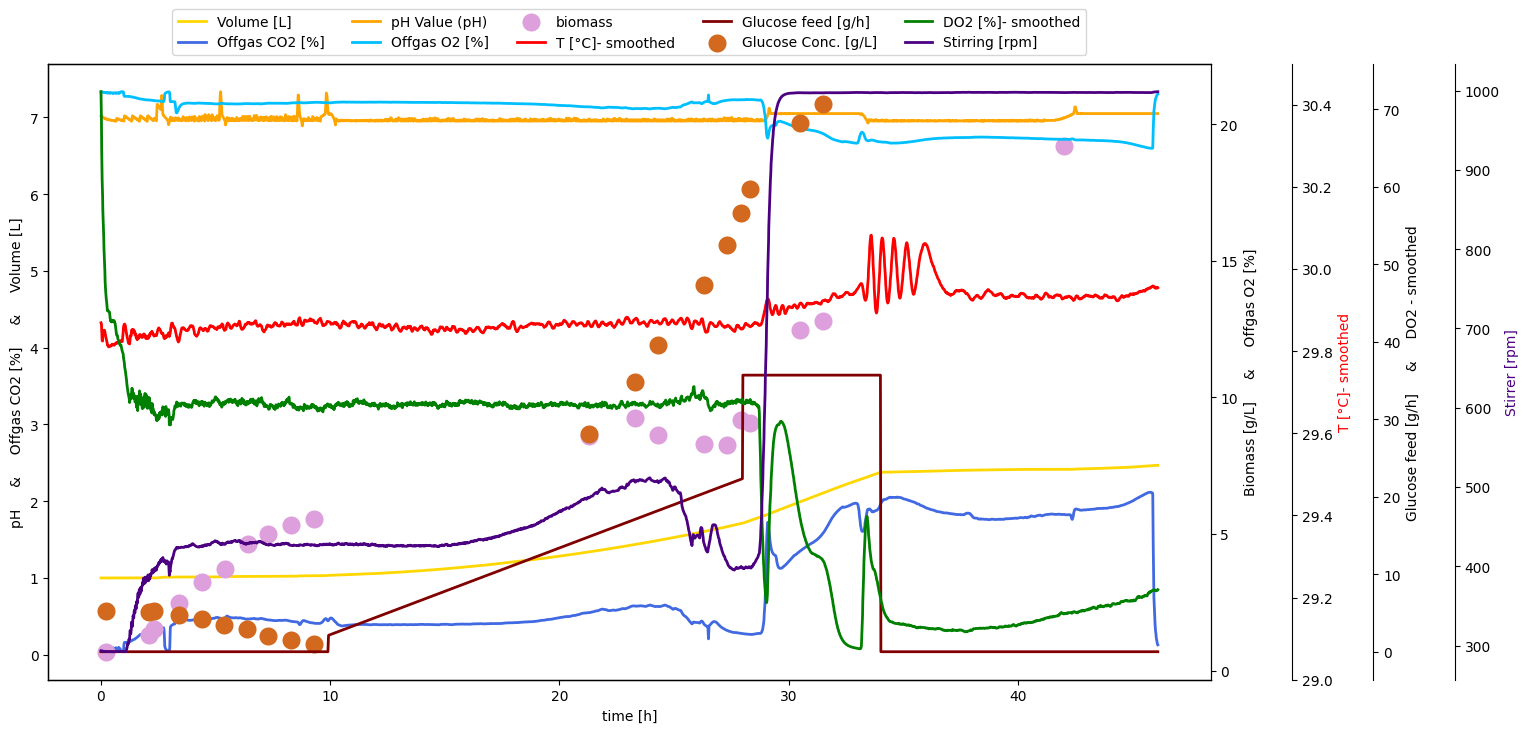

In [26]:
fig, ax = plt.subplots(1,1,figsize=(15,8))

ax_2nd=ax.twinx()
ax_3rd=ax.twinx()
ax_4th=ax.twinx()
ax_5th=ax.twinx()

ax_5th.plot(df['time [h]'], df['Stirring [rpm]- smoothed'], label='Stirring [rpm]', color='indigo', linewidth=2)
ax_4th.plot(df['time [h]'], df['Glucose feed [g/h]'], label='Glucose feed [g/h]', color='maroon', linewidth=2)
ax_4th.scatter(df['time [h]'], df['Glucose [g/L]'], label='Glucose Conc. [g/L]', linewidth=7, color='chocolate')
ax_4th.plot(df['time [h]'], df['DO2 [%]- smoothed'], label='DO2 [%]- smoothed', color='green', linewidth=2)
ax_3rd.plot(df['time [h]'], df['T [°C]- smoothed'], label='T [°C]- smoothed', color='red', linewidth=2)
ax_3rd.set_ylim(29,30.5)
ax_2nd.plot(df['time [h]'], df['Offgas O2 [%]'], label='Offgas O2 [%]', color='deepskyblue', linewidth=2)
ax.plot(df['time [h]'], df['Volume [L]'], label='Volume [L]', color='gold', linewidth=2)
ax.plot(df['time [h]'], df['Offgas CO2 [%]'], label='Offgas CO2 [%]', color='royalblue', linewidth=2)
ax.plot(df['time [h]'], df['pH Value (pH)'], label='pH Value (pH)', color='orange', linewidth=2)
#ax.plot(df['time [h]'], df['Air feed [mL/min]'], label='Flow - Air Value', color='aqua', linewidth=2)
ax_2nd.scatter(df['time [h]'], df['Biomass [g/L]'], linewidth=7, color='plum', label='biomass')

ax_3rd.spines.right.set_position(("axes", 1.07))
ax_4th.spines.right.set_position(("axes", 1.14))
ax_5th.spines.right.set_position(("axes", 1.21))

ax.set_xlabel('time [h]')
ax.set_ylabel('pH     &     Offgas CO2 [%]     &     Volume [L]') #     Flow - Air     &, color='orange'
ax_2nd.set_ylabel('Biomass [g/L]     &     Offgas O2 [%]') #, color='royalblue'
ax_3rd.set_ylabel('T [°C]- smoothed', color='red')
ax_4th.set_ylabel('Glucose feed [g/h]     &     DO2 - smoothed') #, color='green'
ax_5th.set_ylabel('Stirrer [rpm]', color='indigo')

# Get the handles and labels from all the axes
handles, labels = ax.get_legend_handles_labels()
handles_2nd, labels_2nd = ax_2nd.get_legend_handles_labels()
handles_3rd, labels_3rd = ax_3rd.get_legend_handles_labels()
handles_4th, labels_4th = ax_4th.get_legend_handles_labels()
handles_5th, labels_5th = ax_5th.get_legend_handles_labels()

# Combine the handles and labels from all the axes
all_handles = handles + handles_2nd + handles_3rd + handles_4th + handles_5th
all_labels = labels + labels_2nd + labels_3rd + labels_4th + labels_5th

# Create a single legend using the combined handles and labels
ax.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncols=5)

plt.show()

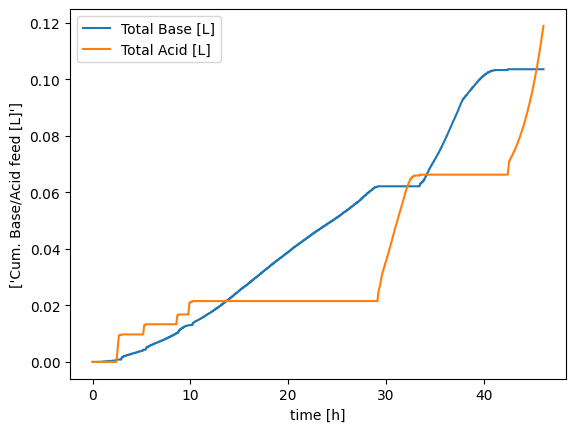

In [22]:
fig, ax = plt.subplots()

ax.plot(df['time [h]'], df[['Cum. Base feed [L/min]', 'Cum. Acid feed [L/min]']], label=['Total Base [L]', 'Total Acid [L]'])

ax.set_xlabel('time [h]')
ax.set_ylabel(['Cum. Base/Acid feed [L]'])
ax.legend()
plt.show()

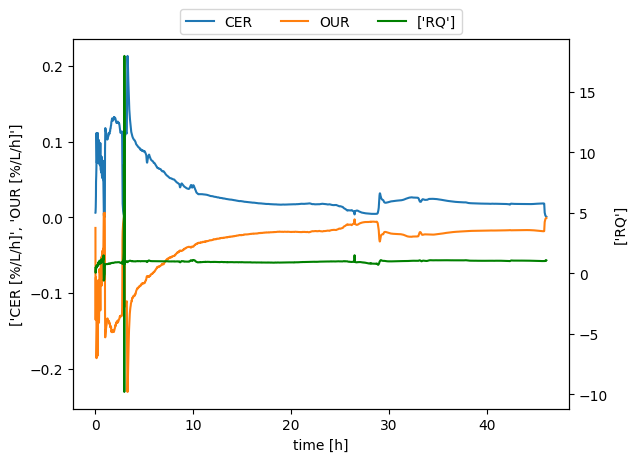

In [23]:
fig, ax = plt.subplots()

ax_sec=ax.twinx()
ax.plot(df['time [h]'], df[['CER [%/L/h]', 'OUR [%/L/h]']], label=['CER', 'OUR'])
ax_sec.plot(df['time [h]'],df['RQ'], label=['RQ'], color='green')

ax.set_xlabel('time [h]')
ax.set_ylabel(['CER [%/L/h]', 'OUR [%/L/h]'])
ax_sec.set_ylabel(['RQ'])
# Get the handles and labels from all the axes
handles, labels = ax.get_legend_handles_labels()
handles_2nd, labels_2nd = ax_sec.get_legend_handles_labels()

# Combine the handles and labels from all the axes
all_handles = handles + handles_2nd
all_labels = labels + labels_2nd

# Create a single legend using the combined handles and labels
ax.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncols=3)

plt.show()

In [24]:
df.shape

(2767, 29)